# Table of Contents

* [Bank Customer Churn Modelling](#modelling)
  * [Understanding the dataset](#understanding)
  * [Visualization](#visualization)
  * [Correlation](#correlation)
* [Transformation](#transformation)
  * [Log Balance](#log-balance)
  * [One-Hot Encoding](#one-hot)
* [Principal Component Analysis (optional)](#pca)
* [Partitioning](#partitioning)
* [Prediction](#prediction)
  * [Logistic Regression](#logistic)
    * [scikit](#scikit)
    * [keras](#keras)
    * [log](#log)
  * [k-NN](#knn)
  * [Decision Tree Classifier](#decision)
  * [Ensemble Methods](#ensemble)
  * [Neural Network](#nn)
* [Model Selection](#selection)

# Bank Customer Churn Modelling <a class="anchor" id="modelling"></a>

Predicting customer churn using this [kaggle dataset](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import QuantileTransformer

%matplotlib inline

## Understanding the dataset <a class="anchor" id="understanding"></a>

In [2]:
bank_data = pd.read_csv("churn_modelling.csv");
display(bank_data.shape) # rows & columns

(10000, 14)

In [3]:
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bank_data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

There are 10000 records. Both RowNumber and CustomerId are unique throughout the entire set, therefore we will remove them. Surname also should not have any information (unless we are profiling by name, which we will not).

In [5]:
display(bank_data.isnull().sum()) # display missing values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
display(bank_data.nunique()) # display unique values

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

There are 10000 rows and no missing values. CustomerID and RowNumber are both unique and can be removed. Surname will also be removed.

In [7]:
bank_data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True);

## Visualization <a class="anchor" id="visualization"></a>

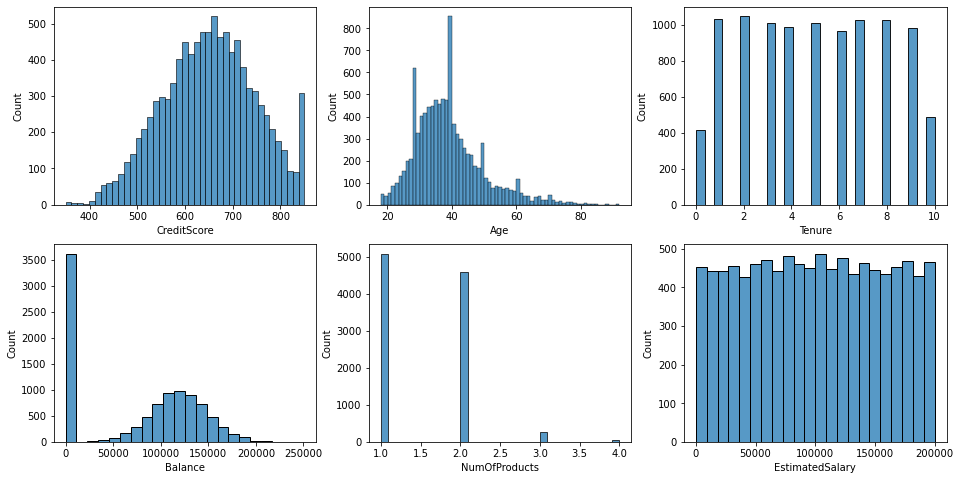

In [8]:
# Display all numeric values
fig, axes = plt.subplots(2, 3, figsize=(16, 8));
sns.histplot(ax=axes[0, 0], data=bank_data["CreditScore"]);
sns.histplot(ax=axes[0, 1], data=bank_data["Age"]);
sns.histplot(ax=axes[0, 2], data=bank_data["Tenure"]);
sns.histplot(ax=axes[1, 0], data=bank_data["Balance"]);
sns.histplot(ax=axes[1, 1], data=bank_data["NumOfProducts"]);
sns.histplot(ax=axes[1, 2], data=bank_data["EstimatedSalary"]);

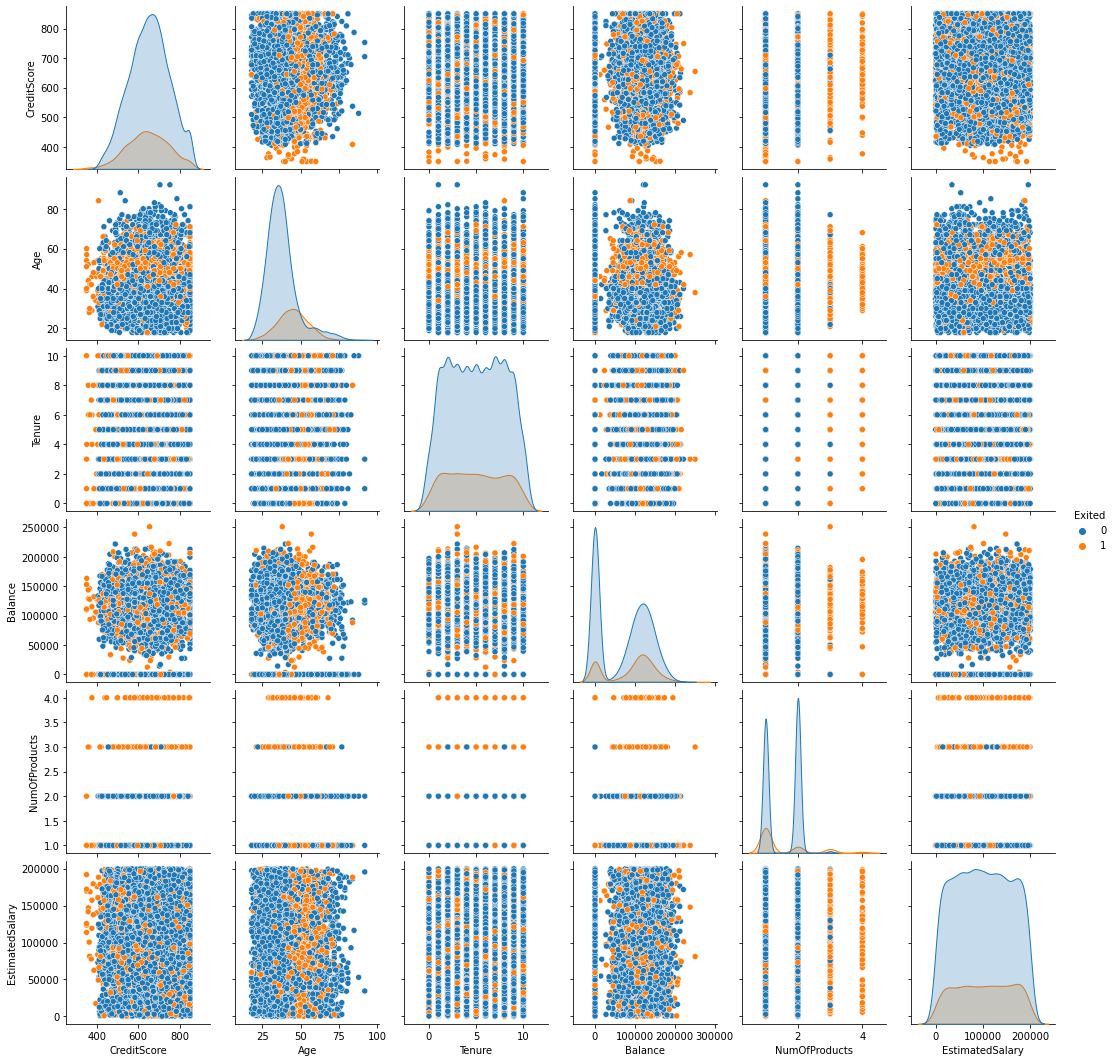

In [9]:
# Plot all numerical variables versus each other
bd_numeric = bank_data[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Exited"]];
sns.pairplot(bd_numeric, hue="Exited");

Observations:

* Balance is bimodal, might need to try a log transformation.
* People with more products tend to exit
* Older people tend to exit

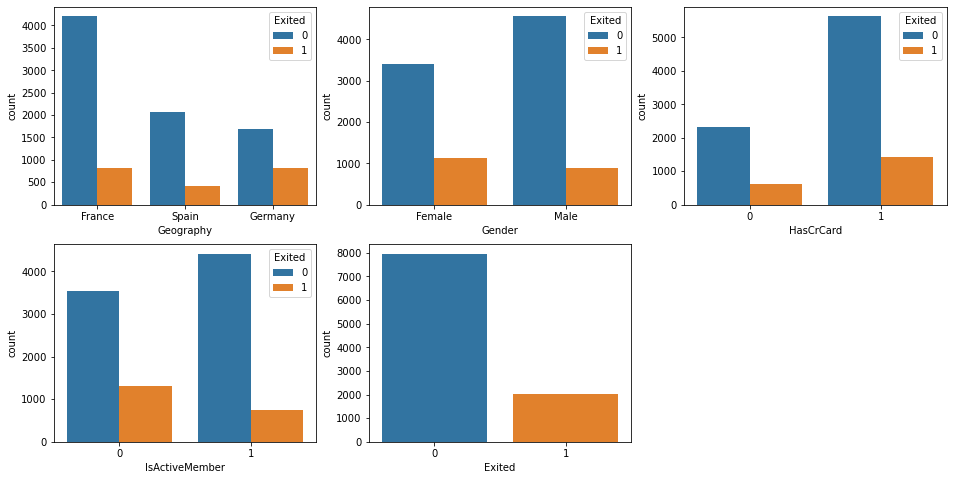

In [10]:
# Plot the categorical variables
fig, axes = plt.subplots(2, 3, figsize=(16, 8));
sns.countplot(ax=axes[0, 0], data=bank_data, x="Geography", hue="Exited");
sns.countplot(ax=axes[0, 1], data=bank_data, x="Gender", hue="Exited");
sns.countplot(ax=axes[0, 2], data=bank_data, x="HasCrCard", hue="Exited");
sns.countplot(ax=axes[1, 0], data=bank_data, x="IsActiveMember", hue="Exited");
sns.countplot(ax=axes[1, 1], data=bank_data, x="Exited");
fig.delaxes(axes[1][2]);

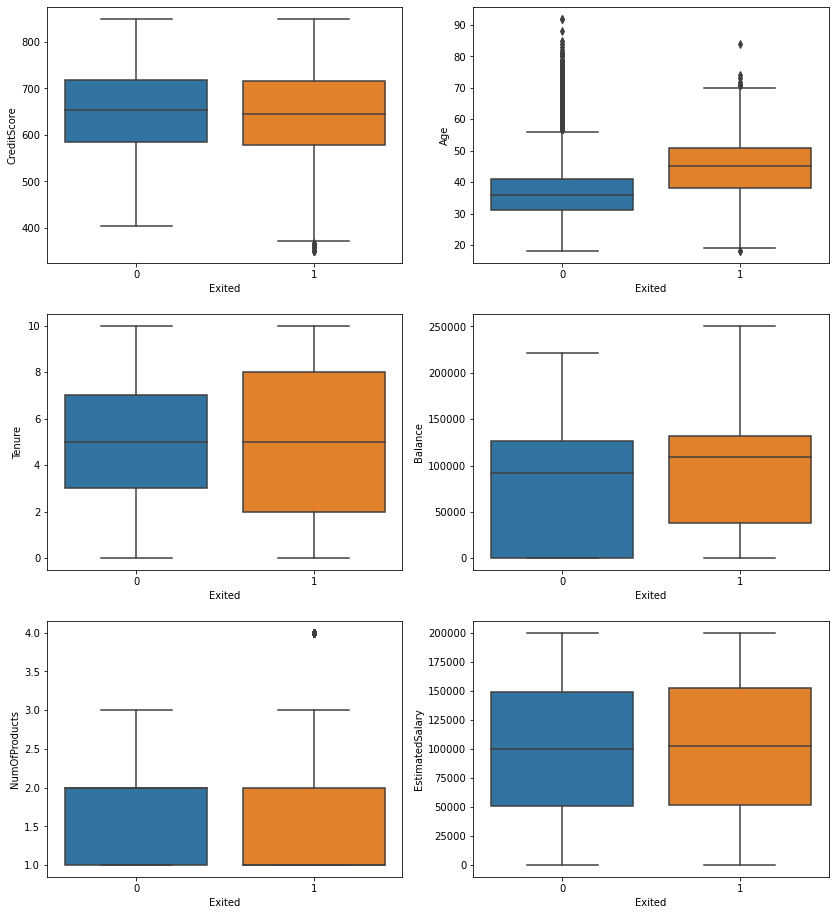

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16));
sns.boxplot(ax=axes[0, 0], data=bank_data, x="Exited", y="CreditScore");
sns.boxplot(ax=axes[0, 1], data=bank_data, x="Exited", y="Age");
sns.boxplot(ax=axes[1, 0], data=bank_data, x="Exited", y="Tenure");
sns.boxplot(ax=axes[1, 1], data=bank_data, x="Exited", y="Balance");
sns.boxplot(ax=axes[2, 0], data=bank_data, x="Exited", y="NumOfProducts");
sns.boxplot(ax=axes[2, 1], data=bank_data, x="Exited", y="EstimatedSalary");

In [12]:
display(pd.crosstab(bank_data["Exited"], bank_data["Geography"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["Geography"], margins=True, normalize=True))

Geography,France,Germany,Spain,All
Exited,,,,
0,4204,1695,2064,7963
1,810,814,413,2037
All,5014,2509,2477,10000


Geography,France,Germany,Spain,All
Exited,,,,
0,0.4204,0.1695,0.2064,0.7963
1,0.0810,0.0814,0.0413,0.2037
All,0.5014,0.2509,0.2477,1.0000


In [13]:
display(pd.crosstab(bank_data["Exited"], bank_data["Gender"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["Gender"], margins=True, normalize=True))

Gender,Female,Male,All
Exited,,,
0,3404,4559,7963
1,1139,898,2037
All,4543,5457,10000


Gender,Female,Male,All
Exited,,,
0,0.3404,0.4559,0.7963
1,0.1139,0.0898,0.2037
All,0.4543,0.5457,1.0000


In [14]:
display(pd.crosstab(bank_data["Exited"], bank_data["HasCrCard"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["HasCrCard"], margins=True, normalize=True))

HasCrCard,0,1,All
Exited,,,
0,2332,5631,7963
1,613,1424,2037
All,2945,7055,10000


HasCrCard,0,1,All
Exited,,,
0,0.2332,0.5631,0.7963
1,0.0613,0.1424,0.2037
All,0.2945,0.7055,1.0000


In [15]:
display(pd.crosstab(bank_data["Exited"], bank_data["IsActiveMember"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["IsActiveMember"], margins=True, normalize=True))

IsActiveMember,0,1,All
Exited,,,
0,3547,4416,7963
1,1302,735,2037
All,4849,5151,10000


IsActiveMember,0,1,All
Exited,,,
0,0.3547,0.4416,0.7963
1,0.1302,0.0735,0.2037
All,0.4849,0.5151,1.0000


## Correlation <a class="anchor" id="correlation"></a>

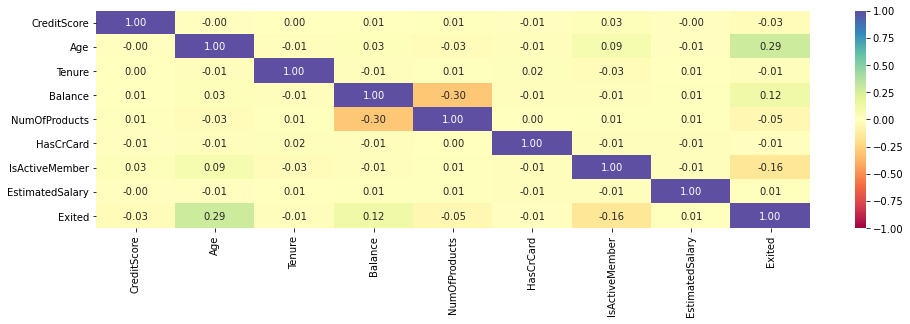

In [16]:
plt.figure(figsize=(16,4));
sns.heatmap(bank_data.corr(), annot=True, fmt=".2f", vmin=-1.0, vmax=1, cmap="Spectral");

# Transformation <a class="anchor" id="transformation"></a>

In [17]:
bank_data_transformed = bank_data;

## Log_Balance <a class="anchor" id="log-balance"></a>
Need to change all 0 balances to 1. This will still be valid for all of the data.

In [18]:
print("         Balance < 0: ", bank_data_transformed[bank_data_transformed["Balance"].lt(0)].shape[0])
print("         Balance = 0: ", bank_data_transformed[bank_data_transformed["Balance"].eq(0)].shape[0])
print("1 <= Balance <= 1000: ", bank_data_transformed[bank_data_transformed["Balance"].between(1, 1000)].shape[0])

         Balance < 0:  0
         Balance = 0:  3617
1 <= Balance <= 1000:  0


In [19]:
bank_data_transformed["Balance_1"] = bank_data_transformed["Balance"].replace(0, 1);
print("         Balance_1 = 0: ", bank_data_transformed[bank_data_transformed["Balance_1"].eq(0)].shape[0])
print("         Balance_1 = 1: ", bank_data_transformed[bank_data_transformed["Balance_1"].eq(1)].shape[0])

         Balance_1 = 0:  0
         Balance_1 = 1:  3617


In [20]:
bank_data_transformed["Log10_Balance_1"] = np.log10(bank_data_transformed["Balance_1"]);

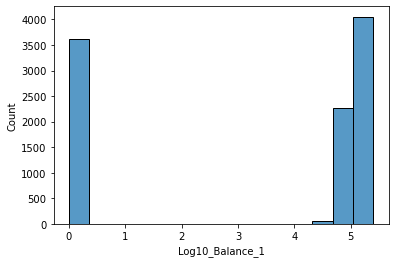

In [21]:
sns.histplot(data=bank_data_transformed["Log10_Balance_1"]);

## One-Hot Encoding <a class="anchor" id="one-hot"></a>

In [22]:
bank_data_transformed = pd.concat([bank_data_transformed,pd.get_dummies(bank_data_transformed['Geography'], prefix='Geography')],axis=1)
bank_data_transformed = pd.concat([bank_data_transformed,pd.get_dummies(bank_data_transformed['Gender'], prefix='Gender')],axis=1)
bank_data_transformed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.00,0.000000,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,83807.86,4.923285,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,159660.80,5.203198,1,0,0,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.00,0.000000,1,0,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,125510.82,5.098681,0,0,1,1,0


# Principal Component Analysis (Optional) <a class="anchor" id="pca"></a>

# Partitioning (60:20:20) <a class="anchor" id="partitioning"></a>

In [23]:
seed=123
bdt_train = bank_data_transformed.sample(frac=0.6, random_state=seed) # Train 60%
bdt_test = bank_data_transformed.drop(bdt_train.index)

bdt_validate = bdt_test.sample(frac=0.5,random_state=seed)   # Validate = 50% of remaining 40% ==> 20%
bdt_test = bdt_test.drop(bdt_validate.index)                 # Test = 20%

print("training set: ", len(bdt_train))
print("validation set: ", len(bdt_validate))
print("test set: ", len(bdt_test))

display(bdt_train.head());
display(bdt_validate.head());
display(bdt_test.head());

training set:  6000
validation set:  2000
test set:  2000


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
2656,779,Spain,Female,34,5,0.00,2,0,1,111676.63,0,1.00,0.000000,0,0,1,1,0
445,748,France,Female,26,1,77780.29,1,0,1,183049.41,0,77780.29,4.890870,1,0,0,1,0
9505,651,France,Male,28,10,79562.98,1,1,1,74687.37,0,79562.98,4.900711,1,0,0,0,1
332,663,Germany,Male,44,2,117028.60,2,0,1,144680.18,0,117028.60,5.068292,0,1,0,0,1
4168,516,France,Male,37,8,0.00,1,1,0,101834.58,0,1.00,0.000000,1,0,0,0,1


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
3089,743,France,Male,40,8,68155.59,1,1,0,94876.65,0,68155.59,4.833501,1,0,0,0,1
7130,599,Germany,Male,33,2,51949.95,2,1,0,85045.92,0,51949.95,4.715585,0,1,0,0,1
5859,721,Spain,Male,38,7,0.00,1,0,1,53534.80,0,1.00,0.000000,0,0,1,0,1
9798,600,Germany,Male,30,2,119755.00,1,1,1,21852.91,0,119755.00,5.078294,0,1,0,0,1
9559,705,Spain,Female,39,8,144102.32,1,1,1,11682.36,0,144102.32,5.158671,0,0,1,1,0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,83807.86,4.923285,0,0,1,1,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,113755.78,5.055973,0,0,1,0,1
13,549,France,Female,25,5,0.00,2,0,0,190857.79,0,1.00,0.000000,1,0,0,1,0
18,587,Spain,Male,45,6,0.00,1,0,0,158684.81,0,1.00,0.000000,0,0,1,0,1
26,756,Germany,Male,36,2,136815.64,1,1,1,170041.95,0,136815.64,5.136136,0,1,0,0,1


# Prediction <a class="anchor" id="prediction"></a>

In [24]:
summary_column_names = ["method", "training_accuracy", "validation_accuracy", "test_accuracy", "f1_score", "auc", "tpr", "fpr"]
summaries = pd.DataFrame(columns = summary_column_names)

## Logistic Regression <a class="anchor" id="logistic"></a>

In [25]:
# First I am going to scale all inputs from 0 to 1 using the min-max method
# minmax = (x_i - x_min) / (x_max - x_min)
scaler = MinMaxScaler()

lr_train_x = scaler.fit_transform(bdt_train[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
lr_train_y = bdt_train["Exited"]

lr_val_x = scaler.fit_transform(bdt_validate[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
lr_val_y = bdt_validate["Exited"]

lr_test_x = scaler.fit_transform(bdt_test[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
lr_test_y = bdt_test["Exited"]

In [26]:
log_train_x = scaler.fit_transform(bdt_train[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
log_train_y = bdt_train["Exited"]

log_val_x = scaler.fit_transform(bdt_validate[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
log_val_y = bdt_validate["Exited"]

log_test_x = scaler.fit_transform(bdt_test[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]])
log_test_y = bdt_test["Exited"]

### Simple Logistic Regression (scikit-learn) <a class="anchor" id="scikit"></a>

In [27]:
lr_model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
lr_model.fit(lr_train_x, lr_train_y)
y_scores = lr_model.predict_proba(lr_test_x);
y_scores=y_scores[:,1]
y_pred = y_scores > 0.5

array([[1479,  107],
       [ 294,  120]])

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1586
           1       0.53      0.29      0.37       414

    accuracy                           0.80      2000
   macro avg       0.68      0.61      0.63      2000
weighted avg       0.77      0.80      0.78      2000



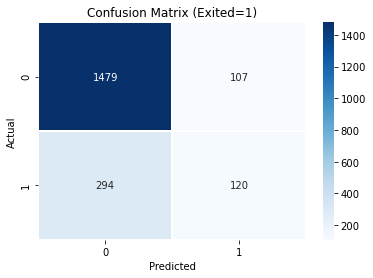

In [28]:
cnf_matrix = confusion_matrix(lr_test_y, y_pred)
display(cnf_matrix)
print(classification_report(lr_test_y, y_pred))

fpr, tpr, threshold = roc_curve(lr_test_y.to_numpy(), y_scores)

summary = pd.DataFrame([["slr-scikit",
               lr_model.score(lr_train_x, lr_train_y),
               lr_model.score(lr_val_x, lr_val_y),
               accuracy_score(lr_test_y, y_pred),
               f1_score(lr_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)")
fig.set_ylabel("Actual")
fig.set_xlabel("Predicted");

### Simple Logistic Regression (Keras) <a class="anchor" id="keras"></a>

In [29]:
# 2-class logistic regression in Keras
lrk_model = Sequential()
lrk_model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid', input_dim=lr_train_x.shape[1]))
lrk_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
lrk_history = lrk_model.fit(x=lr_train_x, y=lr_train_y, epochs=100, validation_data=(lr_val_x, lr_val_y), verbose=0);

**Note: This model takes around 30s to run**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


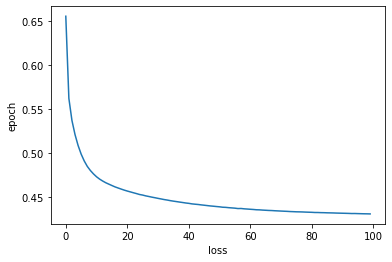

In [30]:
lrk_model.summary();
fig = sns.lineplot(data=lrk_history.history['loss']);
fig.set(xlabel="loss", ylabel = "epoch");

array([[1514,   72],
       [ 316,   98]])

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1586
           1       0.58      0.24      0.34       414

    accuracy                           0.81      2000
   macro avg       0.70      0.60      0.61      2000
weighted avg       0.78      0.81      0.77      2000



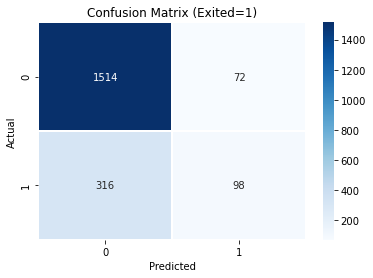

In [31]:
# Predict output, confusion matrix, and ROC curve
lrk_y_pred = lrk_model.predict(lr_test_x);
y_pred = lrk_y_pred > 0.5

cnf_matrix = confusion_matrix(lr_test_y, y_pred)
display(cnf_matrix)
print(classification_report(lr_test_y, y_pred))

fpr, tpr, threshold = roc_curve(lr_test_y.to_numpy(), lrk_y_pred)

summary = pd.DataFrame([["slr-keras",
               lrk_history.history["binary_accuracy"][-1],
               lrk_history.history["val_binary_accuracy"][-1],
               accuracy_score(lr_test_y, y_pred),
               f1_score(lr_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)");
fig.set_ylabel("Actual");
fig.set_xlabel("Predicted");

### Logistic Regression with Log_Balance and Regularization (Optional) <a class="anchor" id="log"></a>

In [32]:
# 2-class logistic regression in Keras with l2 regularization
#l2_lambda = [0.0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
l2_lambda = 0.0;

log_model = Sequential()
log_model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid', input_dim=log_train_x.shape[1], kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))
log_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
log_history = log_model.fit(x=log_train_x, y=log_train_y, epochs=100, validation_data=(log_val_x, log_val_y), verbose=0);

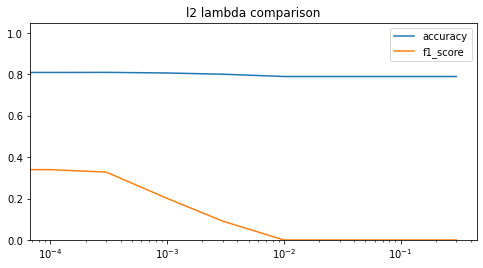

In [33]:
# Results from looking at these l2_lambda values
#l2_lambda = [0.0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
recorded_acc = {0.0: 0.811,
 0.0001: 0.809,
 0.0003: 0.8095,
 0.001: 0.8065,
 0.003: 0.8005,
 0.01: 0.7895,
 0.03: 0.7895,
 0.1: 0.7895,
 0.3: 0.7895};

recorded_f1_score = {0.0: 0.3436426116838488,
 0.0001: 0.33968804159445404,
 0.0003: 0.328042328042328,
 0.001: 0.20080321285140562,
 0.003: 0.09090909090909091,
 0.01: 0.0,
 0.03: 0.0,
 0.1: 0.0,
 0.3: 0.0};

fig, axes = plt.subplots(1, 1, figsize=(8, 4));
sns.lineplot(ax=fig.axes[0], x=recorded_acc.keys(), y=recorded_acc.values(), label = "accuracy")
sns.lineplot(ax=fig.axes[0], x=recorded_f1_score.keys(), y=recorded_f1_score.values(), label = "f1_score")
axes.set(xscale="log")
plt.title("l2 lambda comparison");
plt.ylim([0, 1.05]);

**Note: This model takes ~30s to run**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


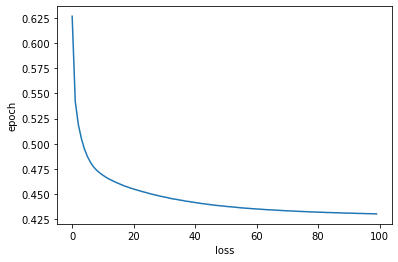

In [34]:
log_model.summary();
fig = sns.lineplot(data=log_history.history['loss']);
fig.set(xlabel="loss", ylabel = "epoch");

array([[1516,   70],
       [ 311,  103]])

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1586
           1       0.60      0.25      0.35       414

    accuracy                           0.81      2000
   macro avg       0.71      0.60      0.62      2000
weighted avg       0.78      0.81      0.78      2000



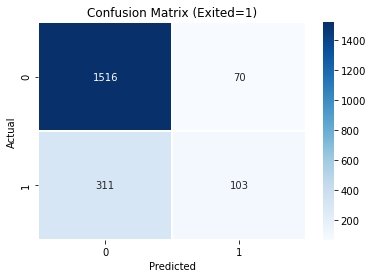

In [35]:
# Predict output, confusion matrix, and ROC curve
log_y_pred = log_model.predict(log_test_x);
y_pred = log_y_pred > 0.5

cnf_matrix = confusion_matrix(log_test_y, y_pred)
display(cnf_matrix)
print(classification_report(log_test_y, y_pred))

fpr, tpr, threshold = roc_curve(log_test_y.to_numpy(), log_y_pred)

summary = pd.DataFrame([["slr-keras-reg",
               log_history.history["binary_accuracy"][-1],
               log_history.history["val_binary_accuracy"][-1],
               accuracy_score(log_test_y, y_pred),
               f1_score(log_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)");
fig.set_ylabel("Actual");
fig.set_xlabel("Predicted");

## k-NN <a class="anchor" id="knn"></a>

In [36]:
knn_train_x = scaler.fit_transform(bdt_train[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
knn_train_y = bdt_train["Exited"]

knn_val_x = scaler.fit_transform(bdt_validate[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
knn_val_y = bdt_validate["Exited"]

knn_test_x = scaler.fit_transform(bdt_test[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
knn_test_y = bdt_test["Exited"]

In [37]:
neighbor_column_names = ["n", "validation_accuracy", "f1_score"]
neighbors = pd.DataFrame(columns = neighbor_column_names)

for n in range(3, 30):
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(knn_train_x, knn_train_y)
    y_scores = knn_model.predict_proba(knn_test_x);
    y_pred = knn_model.predict(knn_test_x);
    y_scores=y_scores[:,1]
    y_pred = y_scores > 0.5    
    neighbor = pd.DataFrame([[n,
                             knn_model.score(knn_val_x, knn_val_y),
                             f1_score(knn_test_y, y_pred)
              ]], 
             columns=neighbor_column_names);
    neighbors = neighbors.append(neighbor, ignore_index=True);

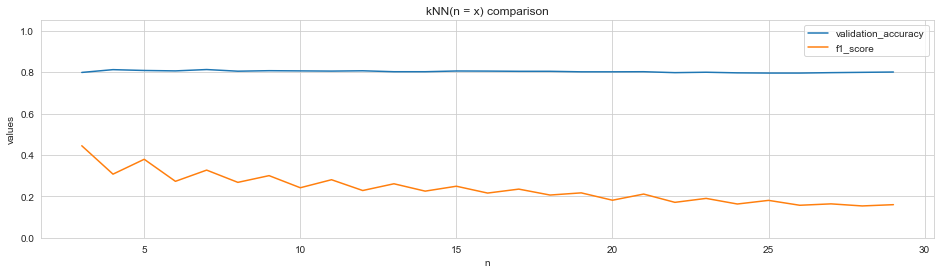

In [38]:
reshaped_neighbors = pd.melt(neighbors, id_vars="n", var_name="metric", value_name="values")
plt.figure(figsize=(16,4))
sns.set_style("whitegrid")
fig = sns.lineplot(data=reshaped_neighbors, x="n", y="values", hue="metric");
fig.set_title("kNN(n = x) comparison");
fig.legend(loc='best');
fig.set_ylim([0, 1.05]);

In [39]:
max_neighbor = neighbors.at[neighbors["f1_score"].idxmax(), "n"]
knn_model = KNeighborsClassifier(n_neighbors=max_neighbor)
knn_model.fit(knn_train_x, knn_train_y)
y_scores = knn_model.predict_proba(knn_test_x);
y_scores=y_scores[:,1]
y_pred = y_scores > 0.5

array([[1468,  118],
       [ 262,  152]])

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1586
           1       0.56      0.37      0.44       414

    accuracy                           0.81      2000
   macro avg       0.71      0.65      0.66      2000
weighted avg       0.79      0.81      0.79      2000



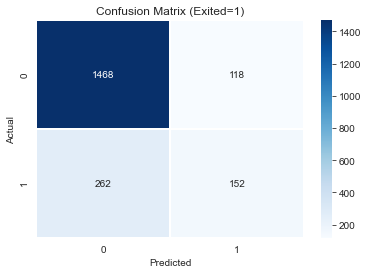

In [40]:
cnf_matrix = confusion_matrix(knn_test_y, y_pred)
display(cnf_matrix)
print(classification_report(knn_test_y, y_pred))

fpr, tpr, threshold = roc_curve(knn_test_y.to_numpy(), y_scores)

summary = pd.DataFrame([["knn[n =" + str(max_neighbor) + "]",
               knn_model.score(knn_train_x, knn_train_y),
               knn_model.score(knn_val_x, knn_val_y),
               accuracy_score(knn_test_y, y_pred),
               f1_score(knn_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)");
fig.set_ylabel("Actual");
fig.set_xlabel("Predicted");

## Decision Tree Classifier <a class="anchor" id="decision"></a>

In [41]:
dtc_train_x = scaler.fit_transform(bdt_train[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
dtc_train_y = bdt_train["Exited"]

dtc_val_x = scaler.fit_transform(bdt_validate[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
dtc_val_y = bdt_validate["Exited"]

dtc_test_x = scaler.fit_transform(bdt_test[["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
dtc_test_y = bdt_test["Exited"]

In [42]:
dtc_model = DecisionTreeClassifier()
dtc_tree = dtc_model.fit(dtc_train_x, dtc_train_y)
y_scores = dtc_model.predict_proba(dtc_test_x);

y_scores = y_scores[:,1]
y_pred = y_scores > 0.5

In [43]:
print(tree.export_text(dtc_tree))

|--- feature_1 <= 0.33
|   |--- feature_4 <= 0.50
|   |   |--- feature_4 <= 0.17
|   |   |   |--- feature_1 <= 0.28
|   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |--- feature_3 <= 0.88
|   |   |   |   |   |   |--- feature_1 <= 0.17
|   |   |   |   |   |   |   |--- feature_7 <= 0.98
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.01
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1 >  0.01
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.49
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.41
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_3 >  0.41
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.49
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |

array([[1312,  274],
       [ 203,  211]])

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1586
           1       0.44      0.51      0.47       414

    accuracy                           0.76      2000
   macro avg       0.65      0.67      0.66      2000
weighted avg       0.78      0.76      0.77      2000



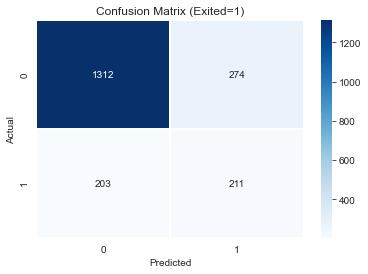

In [44]:
cnf_matrix = confusion_matrix(dtc_test_y, y_pred)
display(cnf_matrix)
print(classification_report(dtc_test_y, y_pred))

fpr, tpr, threshold = roc_curve(knn_test_y.to_numpy(), y_scores)

summary = pd.DataFrame([["decision tree",
               dtc_model.score(dtc_train_x, dtc_train_y),
               dtc_model.score(dtc_val_x, dtc_val_y),
               accuracy_score(dtc_test_y, y_pred),
               f1_score(dtc_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)");
fig.set_ylabel("Actual");
fig.set_xlabel("Predicted");

## Ensemble <a class="anchor" id="ensemble"></a>

## Neural Network (Optional) <a class="anchor" id="nn"></a>

In [45]:
quantile = QuantileTransformer(output_distribution='normal')

nn_train_x = quantile.fit_transform(bdt_train[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
nn_train_y = bdt_train["Exited"]

nn_val_x = quantile.fit_transform(bdt_validate[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
nn_val_y = bdt_validate["Exited"]

nn_test_x = quantile.fit_transform(bdt_test[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]])
nn_test_y = bdt_test["Exited"]

In [46]:
## Inputs
## 16 hidden layers (relu)
## Dropout (0.2)
## 32 hidden layers (relu)
## Dropout (0.2)
## Output - sigmoid

parameters = {
    'l2_regularizer': 0.001,
    'first_layer': 32,
    'second_layer': 64,
    'dropout': 0.2,
    'activation': 'relu',
    'optimizer': 'adam',
    'batch_size': 32,
    'epochs': 200,
    'verbosity': 0
}

In [47]:
## Neural network architecture
## https://medium.com/finc-engineering/user-churn-prediction-using-neural-network-with-keras-c48f23ef4e8b
## http://drunkendatascience.com/predicting-customer-churn-with-neural-networks-in-keras/
## - Dropouts to decrease over fitting (if necessary_)

nn_model = Sequential()
nn_model.add(Dense(parameters['first_layer'],
            input_dim=nn_train_x.shape[1],
            kernel_regularizer=tf.keras.regularizers.l2(parameters['l2_regularizer']),  
            activation=parameters['activation']))
nn_model.add(Dropout(rate=parameters['dropout']))
nn_model.add(Dense(parameters['second_layer'],
            kernel_regularizer=tf.keras.regularizers.l2(parameters['l2_regularizer']), 
            activation=parameters['activation']))
nn_model.add(Dropout(rate=parameters['dropout']))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

nn_history = nn_model.fit(nn_train_x, nn_train_y, 
                        validation_data=[nn_val_x, nn_val_y],
                        batch_size=parameters['batch_size'],
                        epochs=parameters['epochs'], 
                        verbose=parameters['verbosity'])

**Note: This model takes ~60s to run**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                448       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


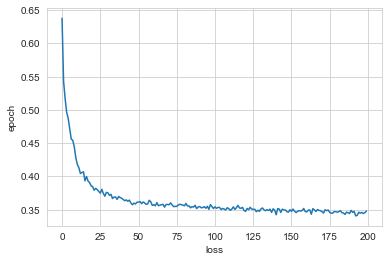

In [48]:
nn_model.summary();
fig = sns.lineplot(data=nn_history.history['loss']);
fig.set(xlabel="loss", ylabel = "epoch");

array([[1544,   42],
       [ 236,  178]])

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1586
           1       0.81      0.43      0.56       414

    accuracy                           0.86      2000
   macro avg       0.84      0.70      0.74      2000
weighted avg       0.86      0.86      0.84      2000



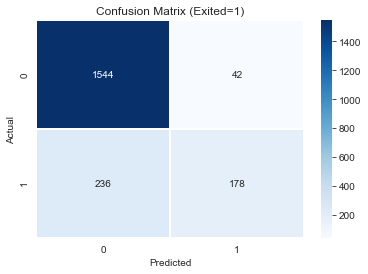

In [49]:
# Predict output, confusion matrix, and ROC curve
nn_y_pred = nn_model.predict(nn_test_x);
y_pred = nn_y_pred > 0.5

cnf_matrix = confusion_matrix(nn_test_y, y_pred)
display(cnf_matrix)
print(classification_report(nn_test_y, y_pred))

fpr, tpr, threshold = roc_curve(nn_test_y.to_numpy(), nn_y_pred)

summary = pd.DataFrame([["neural-network",
               nn_history.history["accuracy"][-1],
               nn_history.history["val_accuracy"][-1],
               accuracy_score(nn_test_y, y_pred),
               f1_score(nn_test_y, y_pred),
               auc(fpr, tpr),
               tpr,
               fpr
              ]], 
             columns=summary_column_names);
summaries = summaries.append(summary, ignore_index=True);

fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
fig.set_title("Confusion Matrix (Exited=1)");
fig.set_ylabel("Actual");
fig.set_xlabel("Predicted");

# Model Selection <a class="anchor" id="selection"></a>

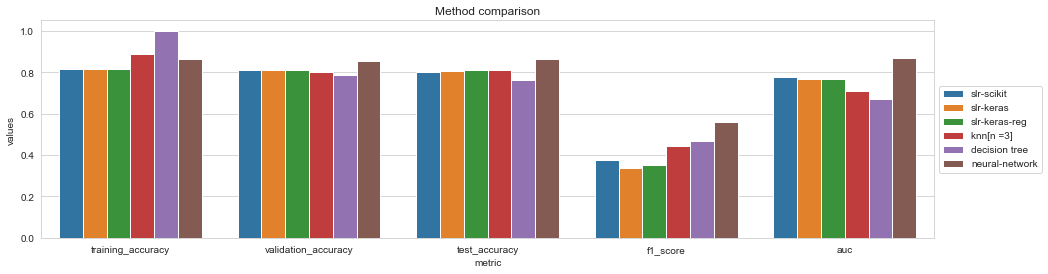

In [50]:
metrics = summaries[["method", "training_accuracy", "validation_accuracy", "test_accuracy", "f1_score", "auc"]]
reshaped_barplot = pd.melt(metrics, id_vars="method", var_name="metric", value_name="values")

plt.figure(figsize=(16,4))
sns.set_style("whitegrid")
fig = sns.barplot(data=reshaped_barplot, x="metric", y="values", hue="method");
fig.set_title("Method comparison");
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_ylim([0, 1.05]);

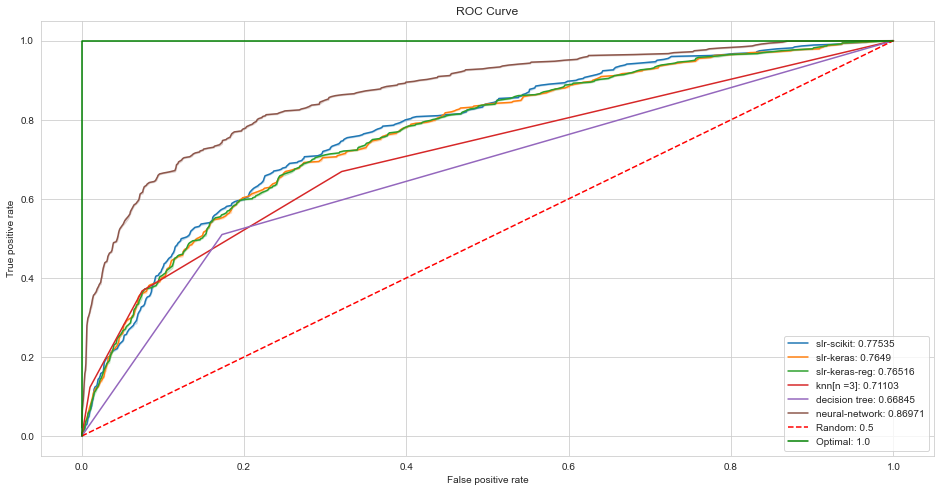

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8));

for index, row in summaries.iterrows():
    sns.lineplot(ax=fig.axes[0], x=row["fpr"], y=row["tpr"], label = row["method"] + ": " + str(round(row["auc"], 5)))

plt.plot([0,1], [0,1], 'r--', label = 'Random: 0.5')
plt.plot([0,0,1], [0,1,1], 'g-', label = 'Optimal: 1.0')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()